In [1]:
from utils import get_artist, get_biggest_arts
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AutoTokenizer
from bert_lightning import chunks_from_artists
from transformers import DataCollatorWithPadding
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import gc
from torch.cuda import empty_cache

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

accuracy = evaluate.load("accuracy")


MODEL_NAME = "distilbert/distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

top30 = get_biggest_arts(30)
top10 = top30[:10]
modes = ["solo", "features"]
song_limits_10 = [110, 180]
song_limits_30 = [190,300]
arts_lists = [top10, top30]
combined = [(top30,"solo",110), (top30,"features",180)] + [(top10,"solo", 190), (top10,"features",300)]



2024-07-01 23:03:00.730849: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 23:03:00.758506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 23:03:01.347192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|██████████| 1049/1049 [00:07<00:00, 137.10it/s]21it/s] 
sorting artists by lyrics length: 1049it [00:07, 136.99it/s]


In [2]:
for arts_list, mode, song_limit in combined:
    label2id = {label: i for i, label in enumerate((a.name_sanitized for a in arts_list))}
    data = chunks_from_artists(arts_list, tokenizer, label2id=label2id, mode=mode, song_limit=song_limit)
    id2label = {i: label for label, i in label2id.items()}
    df = pd.DataFrame(data)
    train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
    train_df_dict = train_df.to_dict(orient='records')
    test_df_dict = test_df.to_dict(orient='records')
    test_dataset, train_dataset = Dataset.from_list(test_df_dict), Dataset.from_list(train_df_dict)
    output_dir = f"models/{len(arts_list)}_{mode}_{song_limit}"

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(label2id.keys()), id2label=id2label, label2id=label2id
        )
    
    print(output_dir, len(train_dataset), len(test_dataset))
    batch_size = 12
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=3e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=6,
        weight_decay=0.01,
        save_total_limit=1,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        # remove_unused_columns=False,
    )

    trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    trainer.save_model(output_dir)
    


Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


models/30_solo_110 6086 1075


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: katnak56 (first_throw). Use `wandb login --relogin` to force relogin


  0%|          | 0/2286 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 

  0%|          | 0/68 [00:00<?, ?it/s]

30_solo_110
sklearn f1:  0.5075183471769503
acc:  0.5203703703703704


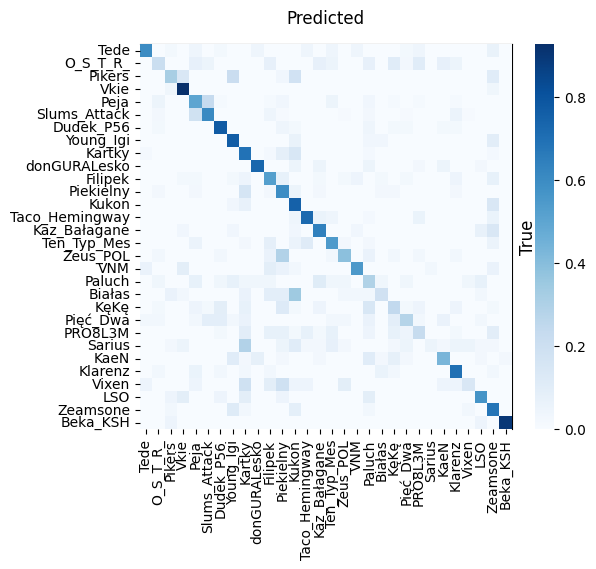

In [3]:
# confussion matrices
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import gc
import seaborn as sns
from sklearn.metrics import f1_score
for arts_list, mode, song_limit in combined:
    label2id = {label: i for i, label in enumerate((a.name_sanitized for a in arts_list))}
    data = chunks_from_artists(arts_list, tokenizer, label2id=label2id, mode=mode, song_limit=song_limit)
    id2label = {i: label for label, i in label2id.items()}
    df = pd.DataFrame(data)
    train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
    train_df_dict = train_df.to_dict(orient='records')
    test_df_dict = test_df.to_dict(orient='records')
    test_dataset, train_dataset = Dataset.from_list(test_df_dict), Dataset.from_list(train_df_dict)
    output_dir = f"models/{len(arts_list)}_{mode}_{song_limit}"

    model = AutoModelForSequenceClassification.from_pretrained(output_dir)

    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=6,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        # remove_unused_columns=False,
    )

    trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        args=training_args,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    # create confusion matrix


    predictions = trainer.predict(test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=1)
    true_labels = [point["label"] for point in test_dataset]
    print(f"{len(arts_list)}_{mode}_{song_limit}")
    acc = sum(p==l for p, l in zip(predicted_labels, true_labels))/len(true_labels)
    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
    print("sklearn f1: ",f1_weighted)
    print('acc: ',  str(acc))
    

    sklearn_confusion_matrix = confusion_matrix(
        list(true_labels), list(predicted_labels), labels=list(label2id.values())
    )
    # normalize the confusion matrix
    # normalize the confusion matrix
    sklearn_confusion_matrix = sklearn_confusion_matrix.astype("float") / sklearn_confusion_matrix.sum(axis=1)[:, np.newaxis]
    fix, ax = plt.subplots(figsize=(6, 5))
    annot = len(arts_list) < 20
    sns.heatmap(
        sklearn_confusion_matrix,
        cmap="Blues",
        annot=annot,
        yticklabels=list(label2id.keys()),
        xticklabels=list(label2id.keys()),
        ax = ax,
    )

    sec_x_ax = ax.secondary_xaxis("top")
    sec_x_ax.set_xlabel("Predicted", fontsize=12, labelpad=15)
    sec_x_ax.set_xticks([])
    sec_y_ax = ax.secondary_yaxis("right")
    sec_y_ax.set_ylabel("True", fontsize=12, labelpad=5)
    sec_y_ax.set_yticks([])
    f_name = f'plots/{len(arts_list)}_{mode}_{song_limit}_{acc:.3f}_{f1_weighted:.3f}.png'
    plt.savefig(f_name, bbox_inches='tight')
    plt.show()
    
    del model
    del trainer
    gc.collect()
    empty_cache()

In [3]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [5]:

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = F.nll_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [6]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    # push_to_hub=True,
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    # tokenizer=tokenizer,
    # data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 